# Combined NASA Aqua and Terra Satellites Overview -- Fraction of Photosynthetically Active Radiation (FPAR) and Leaf Area Index (LAI)
## EDS 220, Fall 2022

#### Authors
- Erika Egg, UC Santa Barbara Bren School of Environmental Science & Management: Master of Environmental Data Science (MEDS), egg@bren.ucsb.edu
- Alessandra Vidal Meza, UC Santa Barbara Bren School of Environmental Science & Management: Master of Environmental Data Science (MEDS), avidalmeza@bren.ucsb.edu
- Elke Windschitl, UC Santa Barbara Bren School of Environmental Science & Management: Master of Environmental Data Science (MEDS), elke@bren.ucsb.edu

## Table of Contents

[1. Purpose](#purpose)

[2. Dataset Description](#overview)

[3. Data I/O](#io)

[4. Metadata Display and Basic Visualization](#display)

[5. Use Case Examples](#usecases)

[6. Now Try it Yourself](#nowtryit)

[7. References](#references)

<a id='purpose'></a> 
## Purpose

The purpose of the notebook is to explore ways to use the [MCD15A3H Version 6.1](https://lpdaac.usgs.gov/products/mcd15a3hv061/) data product produced by MODIS instruments on board the National Aeronautics and Space Administration (NASA)'s Terra and Aqua satellites. MCD15A3H contains data on Fraction of Photosynthetically Active Radiation (FPAR) and Leaf Area Index (LAI), both dimensionless characteristics of plant canopy structure. FPAR refers to the fraction of incoming solar radiation (400−700 nm) that is absorbed by the green entities of a plant canopy, and LAI refers to the amount of leaf material in a plant canopy that is estimated as the one-sided green leaf area per unit ground surface area in a broadleaf canopy and as the one−half of the total needle surface area per unit ground area in a coniferous canopy. 

In the notebook, we provide examples for accessing the data product using Google Earth Engine and reading the data into Python. We provide code to access the bands and create histogram and time series plots as well as two use case examples to compare and contrast FPAR and LAI metrics in the Lacandon Jungle. 

![Image from Pilar Espeso-Molinero and María José Pastor-Alfonso, 2020](map01.png)

The Lacandon Jungle is Maya land and is one of the most biodiverse ecosystems in the world (Levinson 2017). This area is of interest because it is experiencing significant tropical deforestation due to slash-and-burn farming, logging, and cattle raising (Levinson 2017). From 2000 to 2012, 6 percent of the total forest area was lost, or around 500 million trees and more than 32 million tons of biomass (Soberanes 2018). Whatsmore, large climate variability (like the rate of occurrence of events of drought) has affected the jungle's role in directly influencing the local, regional, and even global climate (O'Brien 2008). 

Together, FPAR and LAI allow us to evaluate whether jungle productivity and area over time have spatially changed.

<a id='overview'></a> 
## Dataset Description

The MCD15A3H (Version 6.1) data product observes vegetation canopy structure and soil patterns via Moderate Resolution Imaging Spectroradiometer (MODIS) sensors on the Terra and Aqua satellites, and is published and mantained by NASA since July 4, 2002 (Myneni, Knyazikhin, & Park 2021). Terra's orbit around the Earth is set so that it covers the Equator from north to south in the morning at an altitude of 698 km and Aqua covers it from south to north in the afternoon at an altitude of 705 km. Thus, this data product has a global spatial extent and generated at a 500 meter spatial resolution in a Sinusoidal projection. In addition, the MCD15A3H data product is generated at two temporal resolutions: a 8-day compositing period and a 4-day compositing period (Myneni, Knyazikhin, & Park 2021). Here, we use the a 4-day composite data product. 

The file format of this data product is HDF-EOS (Hierarchical Data Format - Earth Observing System). This is a self-describing data format that is used for [NASA EOS satellites](https://www.hdfeos.org), which include Terra, Aqua, and Aura. Beyond the HDF metadata, there is also an ECS .met file (XML format) available containing a portion of the HDF metadata.

The MCD15A3H data product can be retrieved via NASA Earthdata Search, USGS EarthExplorer, OPeNDAP, and Google Earth Engine. Here, we retrieve the data product via Google Earth Engine given the API's effectiveness to access, manipulate, and visualize freely available geospatial data from several national agencies and universities without a browser. 

The dataset has two data layers reflecting data quality at the pixel level: FparLai_QC and FparExtra_QC. FparLai_QC indicates the quality of the LAI/FPAR algorithm execution. The main situations where data quality may be impacted are: 1) if there are dense canopies, reflectances become saturated and may not properly represent changes in canopy properties or 2) the sun-sensor geometry is collected badly/is too uncertain. If either of these cause the main algorithm to not work properly, then a backup algorithm is used. The best result is the main method being used with no saturation, but if the main method is able to be used despite saturation, this data is still considered “good, very useable.” Cases where a pixel is not able to be produced using either method are also indicated. This information and more can all be found in FparLai_QC, represented as a bit-string. FparExtra_QC includes extra information that could be impacting quality, such as snow/ice presence, aerosol levels, more specific cloud aspects, and land information, also represented as a bit-string. These bit-string variables provide quality information for both FPAR and LAI measurements. Fill values are used within the FPAR and LAI data when biophysical estimates are not able to be generated by an algorithm, or these situations may also be seen represented as missing values, both of which could impact the results of data analysis. In the data for the regions we work with here, only None values are present for FPAR and LAI, which we drop from the data for our tutorial.

Useful data quality links for further exploration:
- [The ArcGIS MODIS-VIIRS Python Toolbox](https://git.earthdata.nasa.gov/projects/LPDUR/repos/arcgis-modis-viirs-python-toolbox/) can be used to help decode the data quality layers.
- Additional information on issues with data by sensor, satellite, and collection version is [available by NASA](https://landweb.modaps.eosdis.nasa.gov/cgi-bin/QS/new/pages.cgi?name=known_issues&_ga=2.136049081.901979973.1668457364-409454201.1668457364).
- [The user guide](https://lpdaac.usgs.gov/documents/926/MOD15_User_Guide_V61.pdf) also contains more in-depth on the data quality information overviewed here. The data quality information above was summarized from this guide.

<a id='io'></a> 
## Dataset Input/Output 

Use the code below to import all packages for analysis in this notebook and authenticate and initialize Google Earth Engine:

In [1]:
# Import packages
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

In [2]:
# Authenticate and initialize GEE
# ee.Authenticate()
ee.Initialize()

Set geometry and reference systems parameters:

In [3]:
# Set region of interest
POI_jungle = ee.Geometry.Point(-91.59522999999996, 16.75) # point for Lacandon Jungle
scale = 10000  # scale in meters

# Set coordinate reference system
crs_4326 = 'EPSG:4326'

Import the [MCD15A3H product](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD15A3H) using Google Earth Engine:

In [4]:
# Load MCD15A3H product for FPAR and LAI data
gdat = ee.ImageCollection('MODIS/061/MCD15A3H')

<a id='display'></a> 
## Metadata Display and Basic Visualization

Below we explore the parameters available for this data product, time series plots for FPAR and LAI in the jungle and the desert, and histograms of FPAR and LAI in the jungle and the desert. We chose to look at time series plot to better understand the seasonality of these metrics, and the differences between our two areas of interest. We decided to create histograms to also better understand differences between our two regions of interest and to understand the spread of our data.

Use the code below to view metadata and metadata parameters of MCD15A3H product:

In [5]:
# Display metadata of MCD15A3H product
first = gdat.first() # pull first image
bands = first.bandNames() # pull band names/variables
str(bands.getInfo()) # view metadata

"['Fpar', 'Lai', 'FparLai_QC', 'FparExtra_QC', 'FparStdDev', 'LaiStdDev']"

To reiterate and consolidate what each of these represent:

**Fpar** - the Fraction of Photosynthetically Active Radiation (FPAR) values

**Lai** - the Leaf Area Index (LAI) values

**FparLai_QC** - bit-strings containing key quality information, such as algorithm used and overall quality of measurement

**FparExtra_QC** - bit-strings containing extra quality information that may also affect results

**FparStdDev** - standard deviations for each FPAR value

**LaiStdDev** - standard deviations for each LAI value

Now, use the code below to make basic time series and histogram plots of FPAR and LAI data for the region of interest:

### Fraction of Photosynthetically Active Radiation in Lacandon Jungle

First, create data frame to use for data visualization:

In [6]:
# Create data frame for FPAR variable in Lacandon Jungle
fparJ = gdat.select('Fpar') # select FPAR band name/variable
fpar_tsJ = fparJ.getRegion(POI_jungle, scale).getInfo() # extract data
df_fparJ = pd.DataFrame(fpar_tsJ).dropna() # save data frame

# Tidy data frame
headers_1 = df_fparJ.loc[0] # extract headers
df_fparJ = pd.DataFrame(df_fparJ.values[1:], columns = headers_1) # add headers
print(df_fparJ) # view data frame 

# Convert time to datetime
df_fparJ['datetime'] = pd.to_datetime(df_fparJ['time'], unit = 'ms')

0             id  longitude  latitude           time Fpar
0     2002_07_04 -91.583243  16.75358  1025740800000   87
1     2002_07_08 -91.583243  16.75358  1026086400000   54
2     2002_07_12 -91.583243  16.75358  1026432000000   40
3     2002_07_16 -91.583243  16.75358  1026777600000   73
4     2002_07_20 -91.583243  16.75358  1027123200000   65
...          ...        ...       ...            ...  ...
1862  2022_11_09 -91.583243  16.75358  1667952000000   89
1863  2022_11_13 -91.583243  16.75358  1668297600000   87
1864  2022_11_17 -91.583243  16.75358  1668643200000   78
1865  2022_11_21 -91.583243  16.75358  1668988800000   64
1866  2022_11_25 -91.583243  16.75358  1669334400000   87

[1867 rows x 5 columns]


Now, let's make a time series plot:

/opt/python/3.10.5/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/python/3.10.5/lib/python3.10/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/python/3.10.5/lib/python3.10/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0, 0.5, 'FPAR (%)')

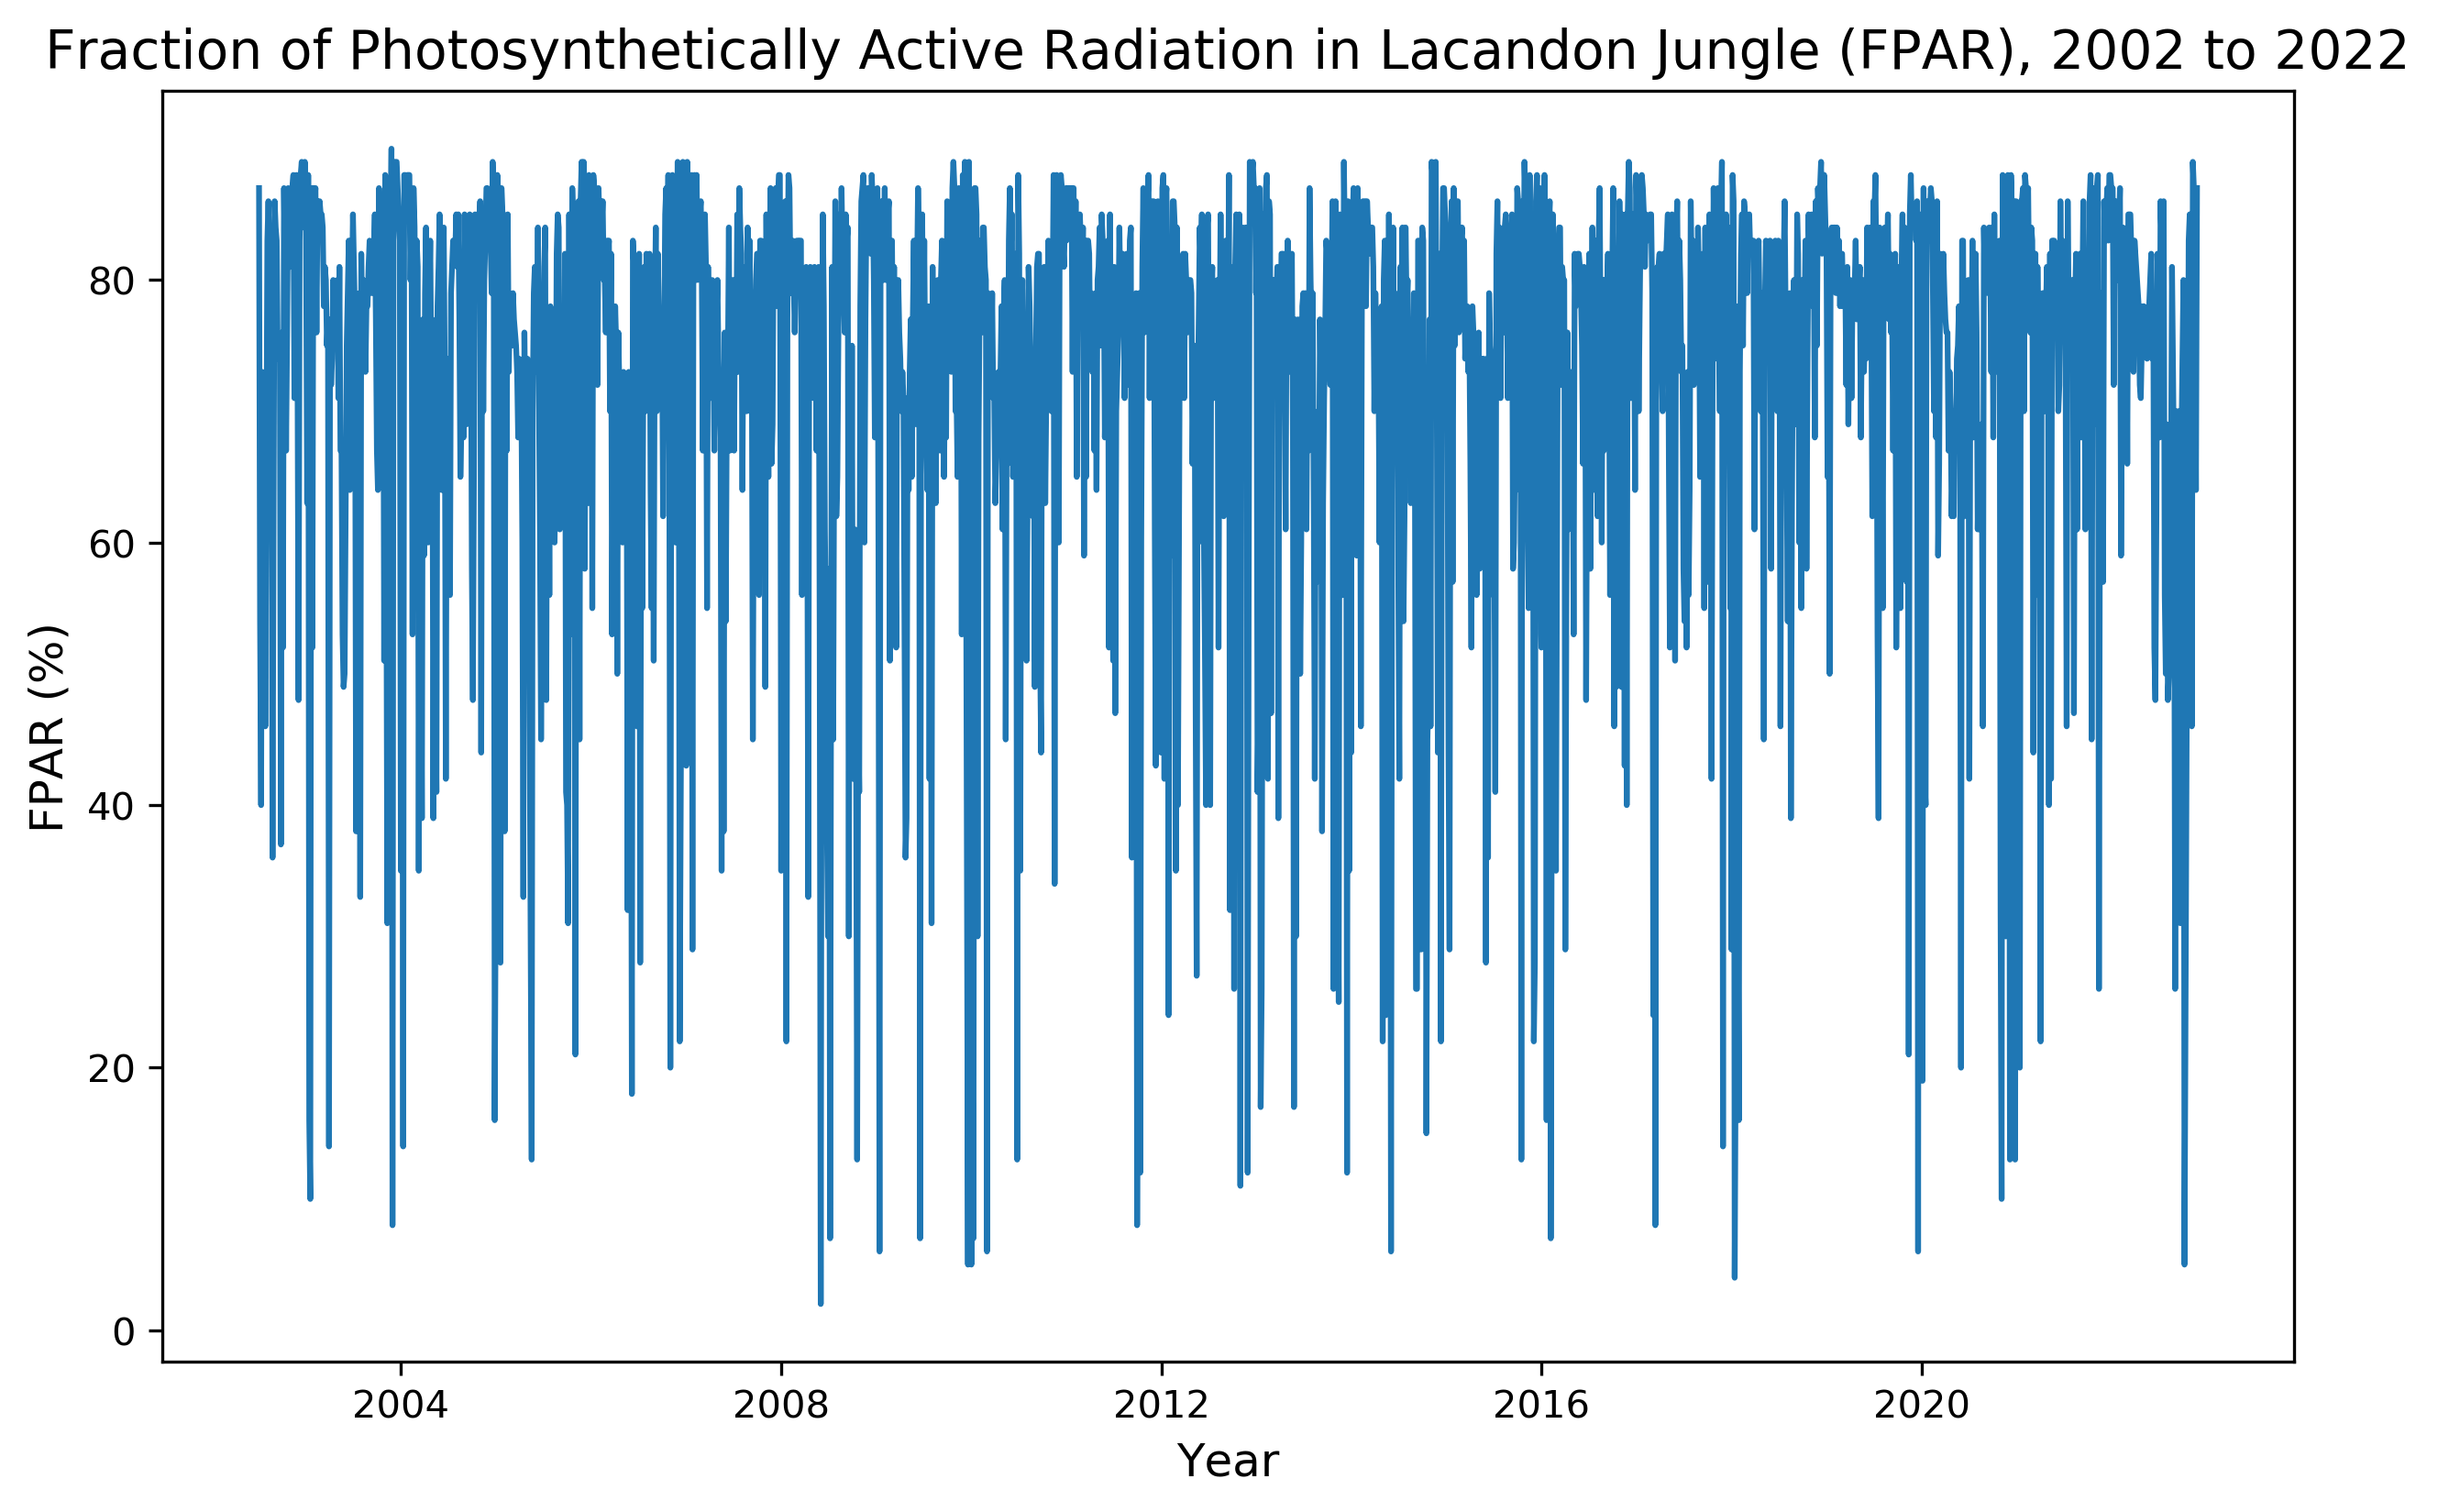

In [7]:
# Plot time series for FPAR variable in Lacandon Jungle
plt.figure(figsize = (10, 6), dpi = 300) # create figure; set size and resolution (dpi)
plt.plot(df_fparJ['datetime'], df_fparJ['Fpar']) # add data to plot
plt.title('Fraction of Photosynthetically Active Radiation in Lacandon Jungle (FPAR), 2002 to 2022', fontsize = 14) # add title to plot
plt.xlabel('Year', fontsize = 12) # add x label to plot
plt.ylabel('FPAR (%)', fontsize = 12) # add y label to plot

And let's make a histogram plot:

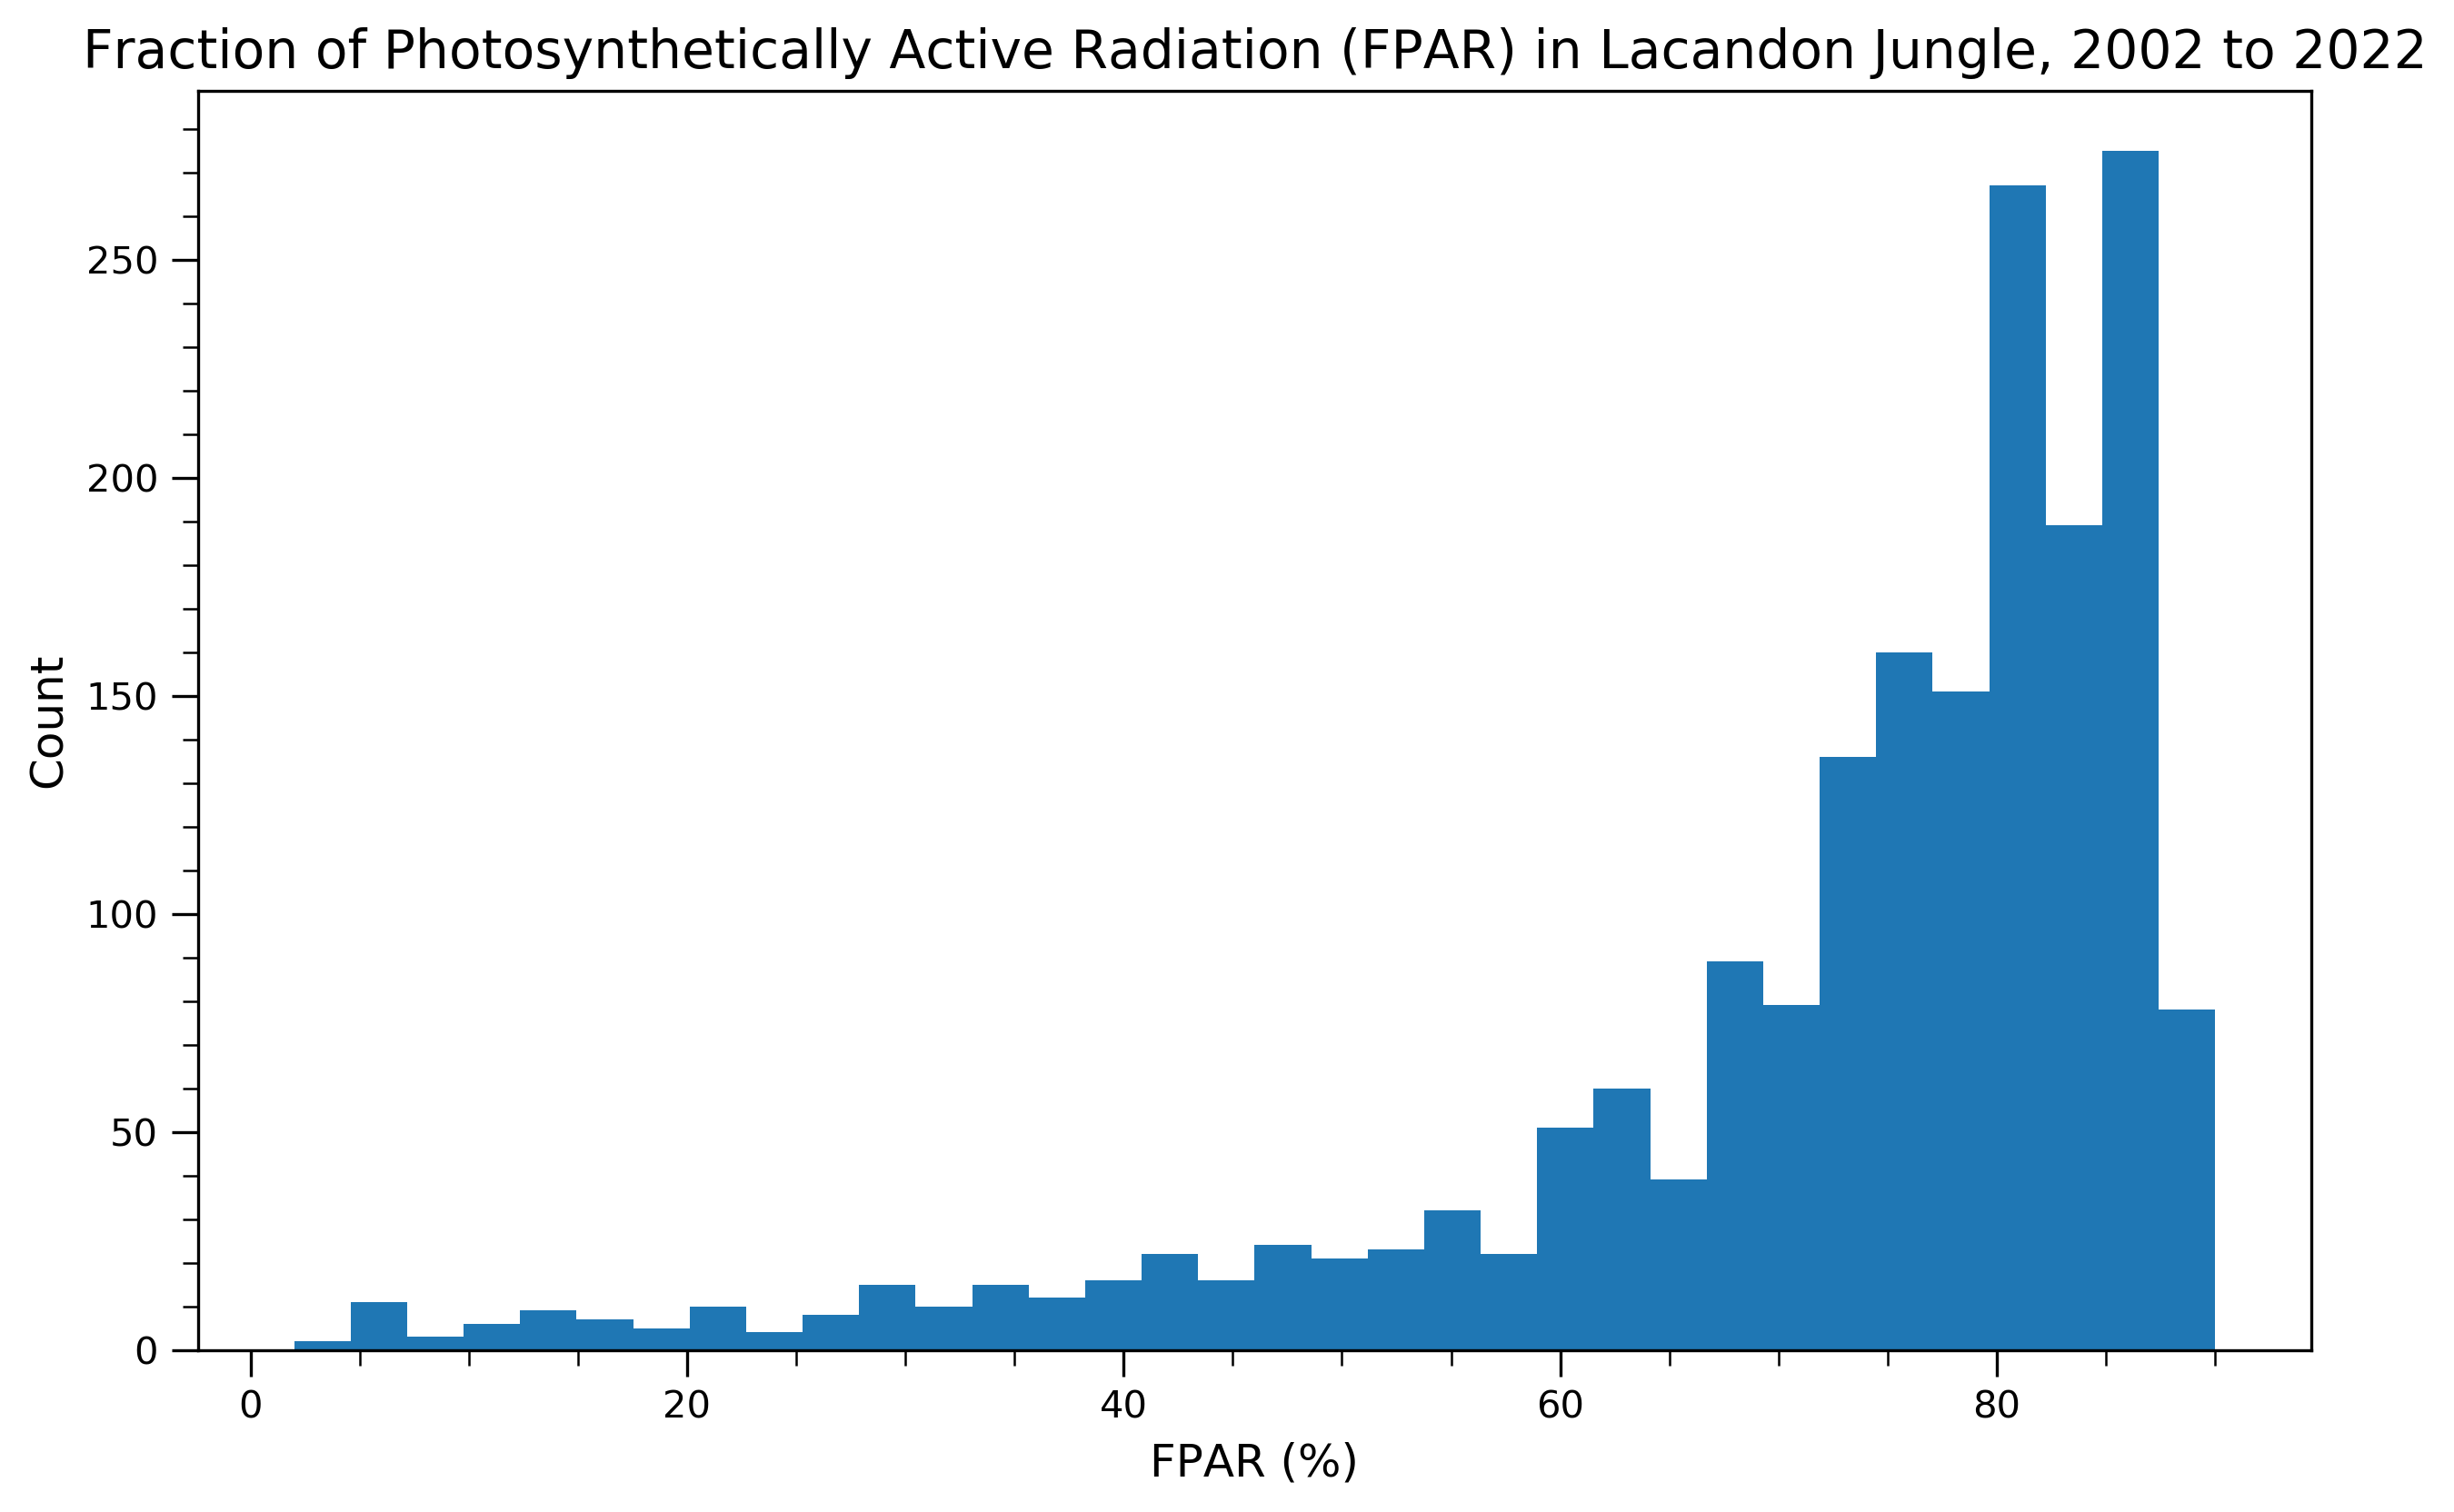

In [8]:
# Plot histogram for FPAR variable in Lacandon Jungle
fig, ax = plt.subplots(figsize = (10, 6), dpi = 300) # create figure; set size and resolution (dpi)
n, bins, patches = ax.hist(x = df_fparJ['Fpar'], bins = 'auto') # add histogram to plot
plt.title('Fraction of Photosynthetically Active Radiation (FPAR) in Lacandon Jungle, 2002 to 2022', fontsize = 14) # add title to plot
plt.xlabel('FPAR (%)', fontsize = 12) # add x label to plot
plt.ylabel('Count', fontsize = 12) # add y label to plot
ax.yaxis.set_minor_locator(AutoMinorLocator()) # set automatic tick selection for y-axis
ax.xaxis.set_minor_locator(AutoMinorLocator()) # set automatic tick selection for x-axis
ax.tick_params(which = 'major', length = 7) # set major ticks
ax.tick_params(which = 'minor', length = 4) # set minor ticks

From our time series and histogram we see that FPAR in the jungle is fairly high on average, but seemingly seasonal with high variablility. The data have a long left tail.

### Leaf Area Index in Lacandon Jungle

Now, we repeat this same process for Leaf Area Index!

First, create data frame to use for data visualization:

In [9]:
# Create data frame for LAI variable in Lacandon Jungle
laiJ = gdat.select('Lai') # select LAI band name/variable
lai_tsJ = laiJ.getRegion(POI_jungle, scale).getInfo() # extract data
df_laiJ = pd.DataFrame(lai_tsJ).dropna() # save data frame

# Tidy data frame
headers_2 = df_laiJ.loc[0] # extract headers
df_laiJ = pd.DataFrame(df_laiJ.values[1:], columns = headers_2) # add headers
print(df_laiJ) # view data frame 

# Convert time to datetime
df_laiJ['datetime'] = pd.to_datetime(df_laiJ['time'], unit = 'ms')

0             id  longitude  latitude           time Lai
0     2002_07_04 -91.583243  16.75358  1025740800000  57
1     2002_07_08 -91.583243  16.75358  1026086400000  28
2     2002_07_12 -91.583243  16.75358  1026432000000  14
3     2002_07_16 -91.583243  16.75358  1026777600000  41
4     2002_07_20 -91.583243  16.75358  1027123200000  30
...          ...        ...       ...            ...  ..
1862  2022_11_09 -91.583243  16.75358  1667952000000  55
1863  2022_11_13 -91.583243  16.75358  1668297600000  54
1864  2022_11_17 -91.583243  16.75358  1668643200000  45
1865  2022_11_21 -91.583243  16.75358  1668988800000  37
1866  2022_11_25 -91.583243  16.75358  1669334400000  54

[1867 rows x 5 columns]


Next, let's make a time series plot:

/opt/python/3.10.5/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/python/3.10.5/lib/python3.10/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/python/3.10.5/lib/python3.10/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0, 0.5, 'Leaf Area Index (m²/m²)')

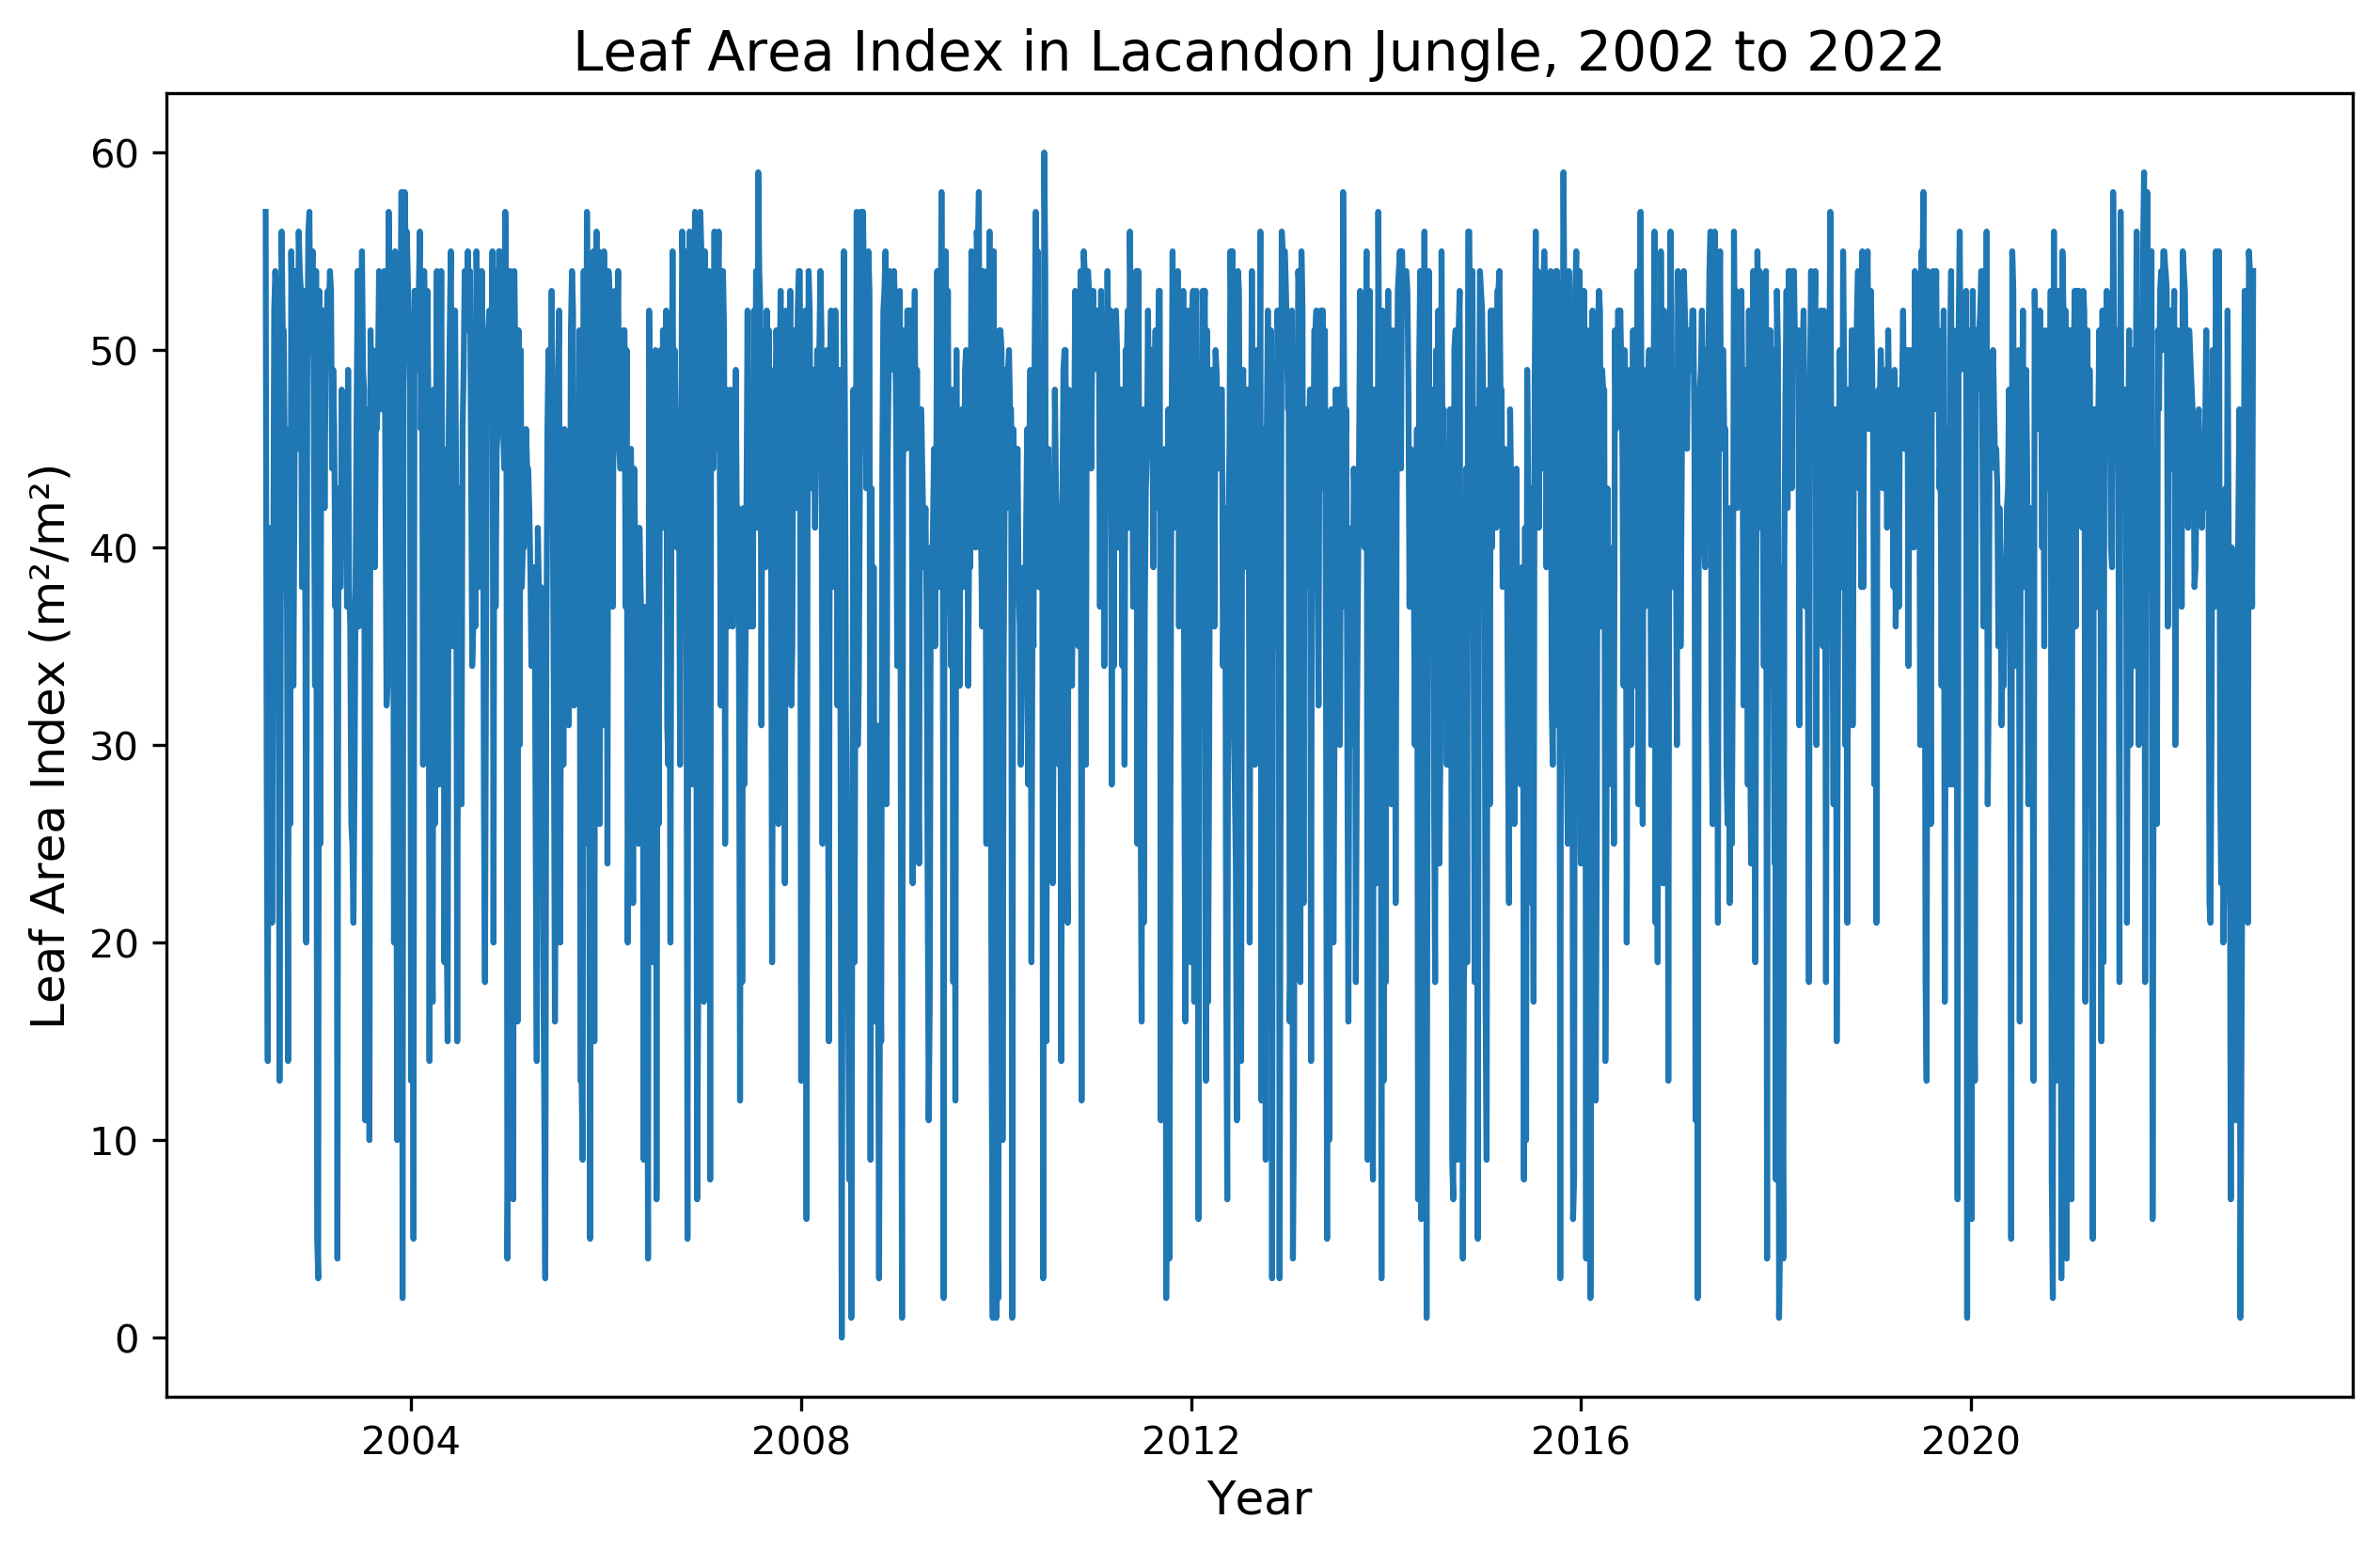

In [10]:
# Plot time series for LAI variable in Lacandon Jungle
plt.figure(figsize = (10, 6), dpi = 300) # create figure; set size and resolution (dpi)
plt.plot(df_laiJ['datetime'], df_laiJ['Lai']) # add data to plot
plt.title('Leaf Area Index in Lacandon Jungle, 2002 to 2022', fontsize = 14) # add title to plot
plt.xlabel('Year', fontsize = 12) # add x label to plot
plt.ylabel('Leaf Area Index (m²/m²)', fontsize = 12) # add y label to plot

And let's make a histogram plot:

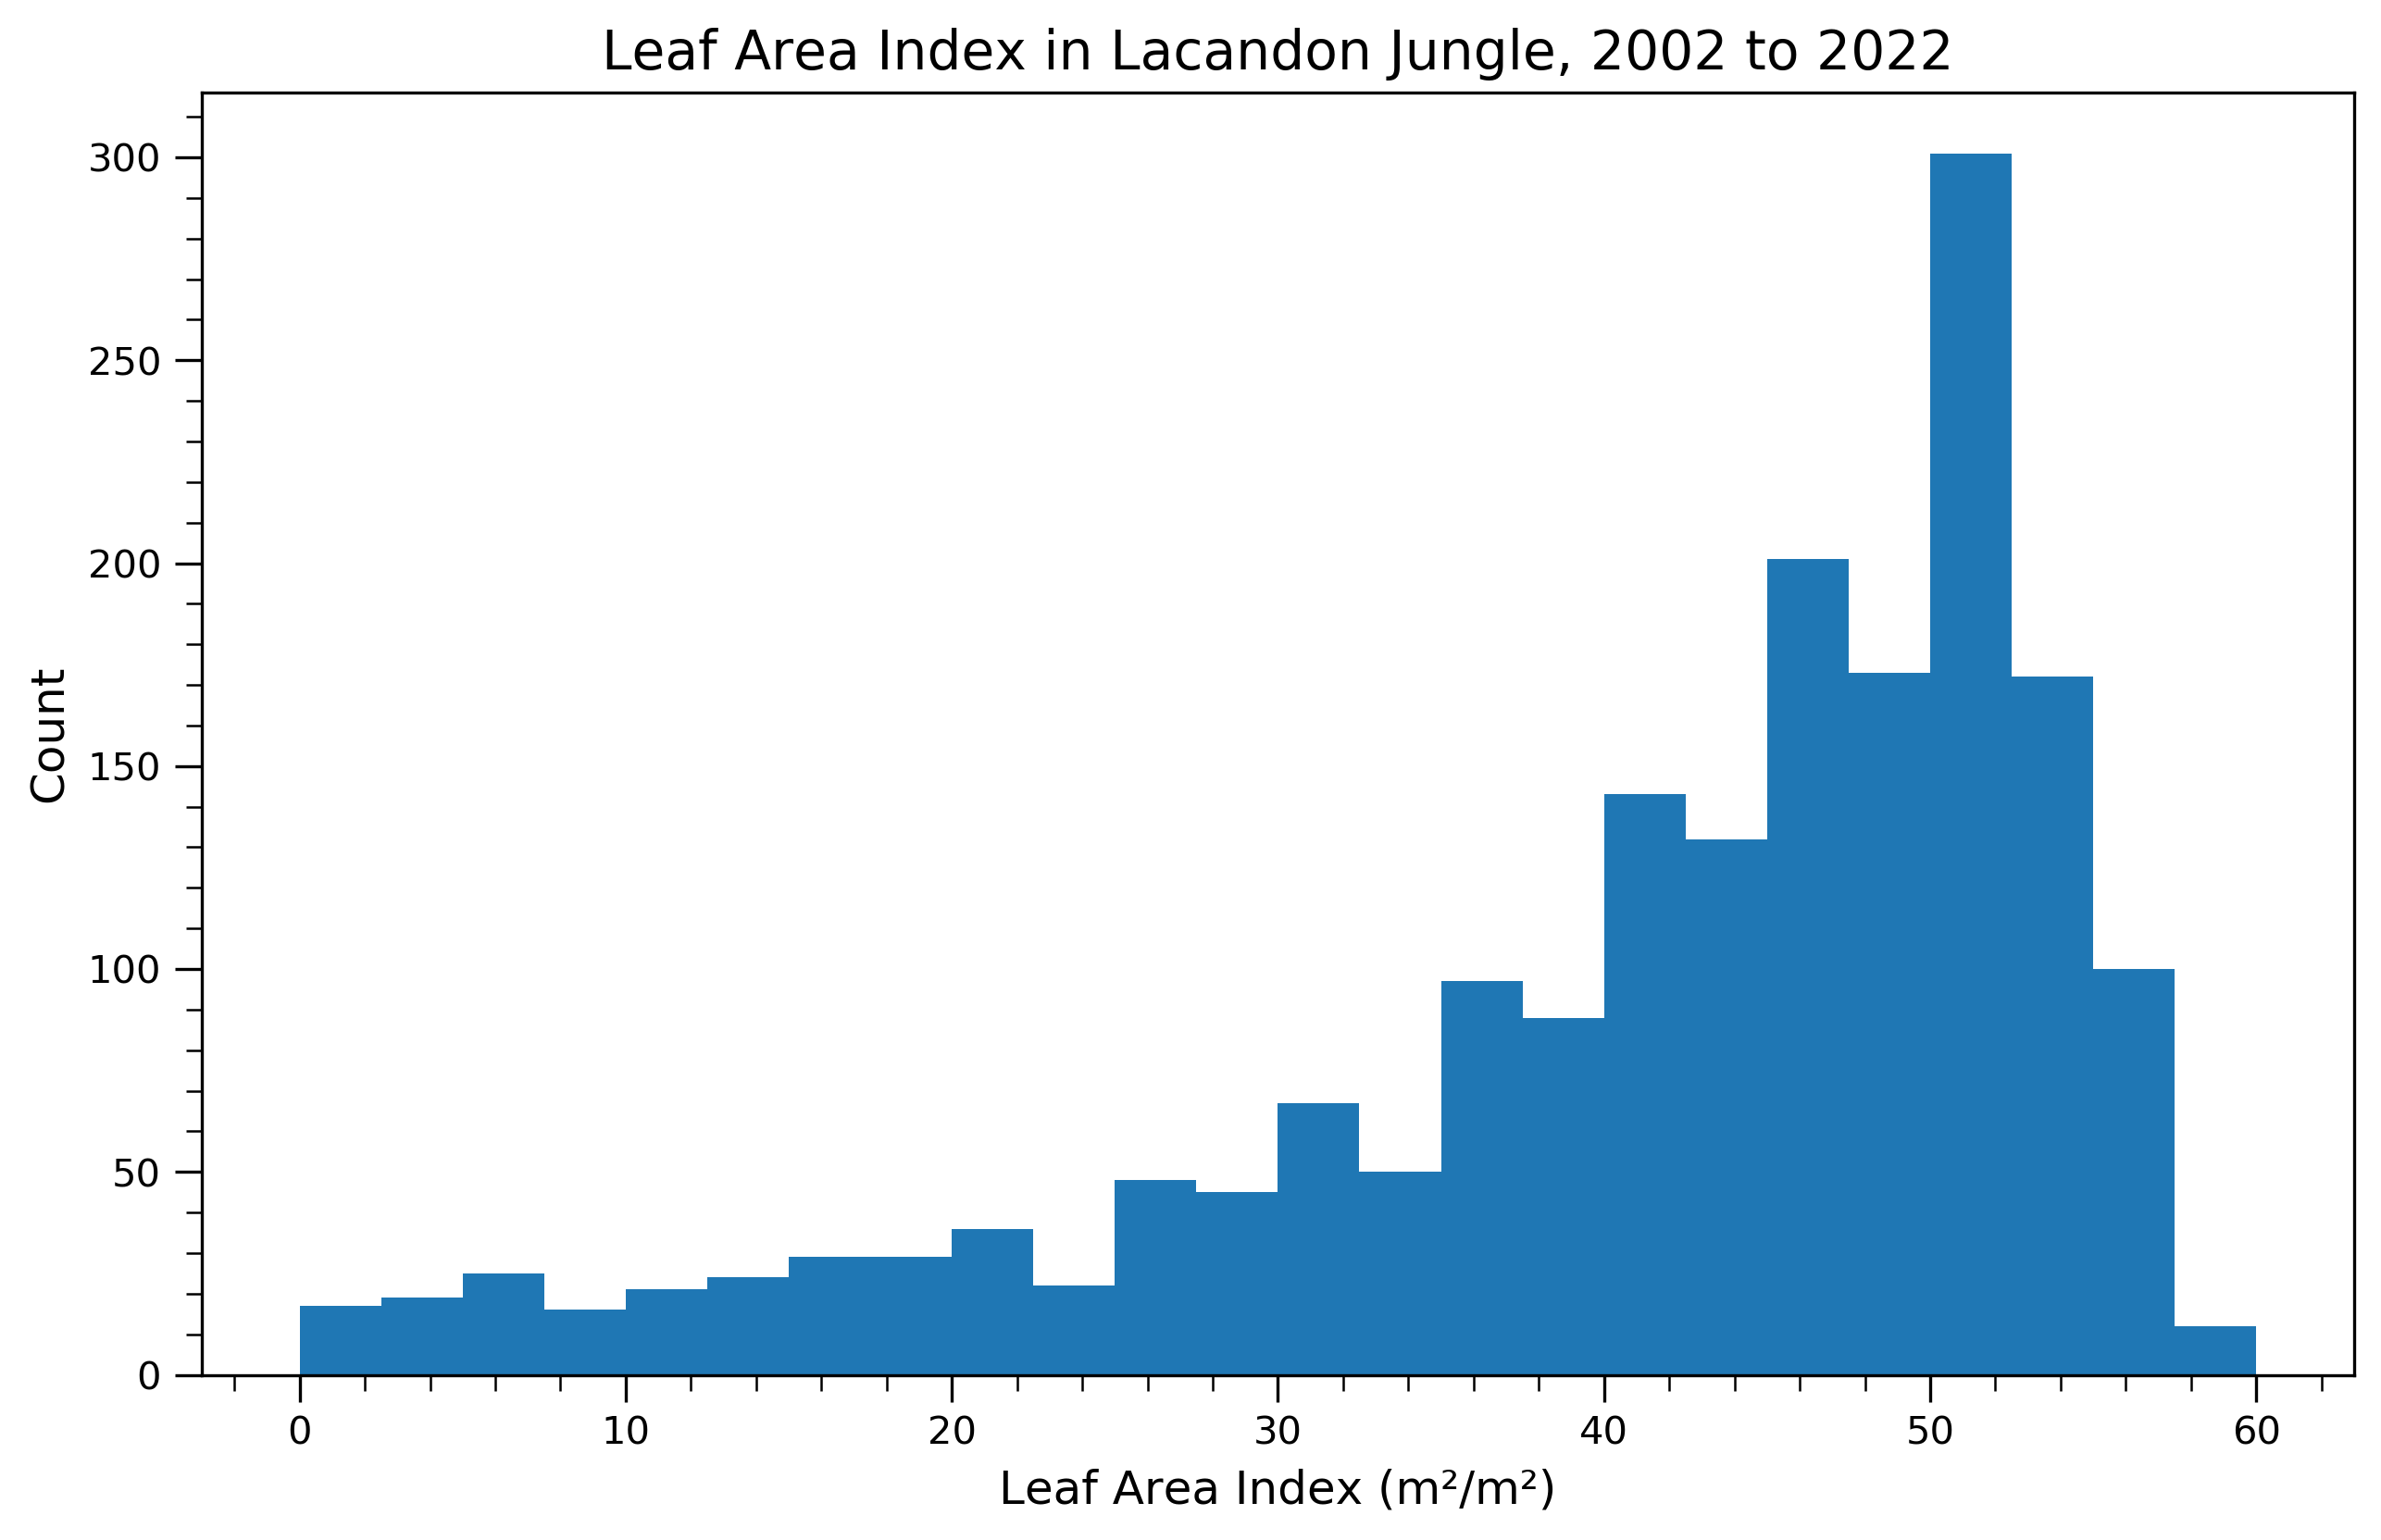

In [11]:
# Plot histogram for LAI variable in Lacandon Jungle
fig, ax = plt.subplots(figsize = (10, 6), dpi = 300) # create figure; set size and resolution (dpi)
n, bins, patches = ax.hist(x = df_laiJ['Lai'], bins = 'auto') # add histogram to plot
plt.title('Leaf Area Index in Lacandon Jungle, 2002 to 2022', fontsize = 14) # add title to plot
plt.xlabel('Leaf Area Index (m²/m²)', fontsize = 12) # add x label to plot
plt.ylabel('Count', fontsize = 12) # add y label to plot
ax.yaxis.set_minor_locator(AutoMinorLocator()) # set automatic tick selection for y-axis
ax.xaxis.set_minor_locator(AutoMinorLocator()) # set automatic tick selection for x-axis
ax.tick_params(which = 'major', length = 7) # set major ticks
ax.tick_params(which = 'minor', length = 4) # set minor ticks

From our time series and histogram we see that LAI in the jungle reaches up to 60%, with high variablility. The data have a long left tail.

<a id='usecases'></a> 
## Use Case Examples

### Summary
Let's now focus on the Lacandon Jungle. Here, we show use case examples for FPAR and LAI during two time periods of interest, 2010 to 2012 and 2020 to 2022. We also include time series plots to show how the FPAR and LAI change day to day over time.

This analysis is useful to evaluate whether jungle productivity and area over time have spatially changed. FPAR is a proxy variable for productivity, as it measures the ratio of light entering a photosynthetic system to the amount of light absorbed and reflected in that system. LAI captures changes in tree canopies over time and the potential for gas exchange and light absorption. For a more complete analysis of productivity, LAI can be evaluated alongside FPAR to understand the potential for light absorption versus the true rate of absorption. Differences between LAI and FPAR could be calculated to identify areas of low LAI and high FPAR -- indicating highly efficient canopies -- or high LAI and low FPAR -- indicating less efficient canopies. These calculations are beyond the scope of our notebook though and not illustrated here. FPAR and LAI can also be used to identify areas of deforestation through time. 

These tools can be used by a number of stakeholders including resource managers, climate scientists, and concerned citizens. Anyone interested in understanding how vegetation and its productivity is changing over time or space might use FPAR and LAI. Outputs from mapping and plotting satellite observations may be used in conservation, resoration, climate models, resource management, or policy evaluation.

### FPAR in Lacandon Jungle

Let's define the time periods of interest and select the band name:

In [12]:
# Select FPAR band name/variable
gee1 = gdat.filter(ee.Filter.date('2010-11-01', '2012-11-01')).select('Fpar').mean() # select for time period of interest 1
gee2 = gdat.filter(ee.Filter.date('2020-11-01', '2022-11-01')).select('Fpar').mean() # select for time period of interest 2

Now, let's create a basemap, add the layer for the mean FPAR from November 2010 to November 2012, and add the layer for the mean FPAR from November 2020 to November 2022:

In [13]:
# Create basemap with spatial parameters for Lacandon Jungle
Map = geemap.Map(center = [16.75, -91.59522999999996], zoom = 10)

In [14]:
# Define palette
palette = ['#fffff9', '#d7eba8', '#addd8e',
          '#78c679', '#41ab5d', '#238443', '#005a32']

# Define visual parameters
visParams = {'bands': ['Fpar'], # select band/variable
             'min': 0, # set minimum parameter
             'max': 100, # set maximum parameter
             'palette': palette} # set palette

# Define color bar
colors = visParams['palette'] # set colors from visual parameters
vmin = visParams['min'] # set minimum from visual parameters
vmax = visParams['max'] # set maximum from visual parameters

# Add layer for time period of interest 1 to the left tile
left  = geemap.ee_tile_layer(gee1, visParams, 'Mean FPAR (%) in Lacandon Jungle from 2010 to 2012')

# Add layer for time period of interest 2 to the right tile
right = geemap.ee_tile_layer(gee2, visParams, 'Mean FPAR (%) in Lacandon Jungle from 2020 to 2022')

# Add tiles to the map
Map.split_map(left, right)

# Add color bar
Map.add_colorbar_branca(colors = colors, 
                        vmin = vmin, 
                        vmax = vmax)
Map # view map

Map(center=[16.75, -91.59522999999996], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…

Now, let's increase the zoom of the map and find a point of change:

In [15]:
# Create basemap with spatial parameters for Lacandon Jungle
Map = geemap.Map(center = [16.75, -91.59522999999996], zoom = 15)

# Add tiles to the map
Map.split_map(left, right)

# Add color bar
Map.add_colorbar_branca(colors = colors, 
                        vmin = vmin, 
                        vmax = vmax)

Map # view map

Map(center=[16.75, -91.59522999999996], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…

Finally, let's make an interactive time series map for FPAR from November 2010 to November 2022:

In [16]:
# Create basemap with spatial parameters for Lacandon Jungle
FPARMap = geemap.Map(center = [16.75, -91.59522999999996], zoom = 9)

# Import collection of images from 2010 to 2022
collection = gdat.filter(ee.Filter.date('2010-11-01', '2022-11-01')).select('Fpar')

# Set first image in collection of images from 2010 to 2022
first_image = collection.first()

# Add layer with first image
FPARMap.addLayer(first_image, visParams, "FPAR (%) in Lacandon Jungle from 2010 to 2022")

# Add all other images in collection of images from 2010 to 2022
image = collection.toBands()

# Add layer with all other images
FPARMap.addLayer(image, {}, "Time series", False)

# Add labels 
labels = collection.aggregate_array("system:index").getInfo()

# Add time slider
FPARMap.add_time_slider(collection, visParams, labels = labels, time_interval = 1)

# Add color legend
FPARMap.add_colorbar_branca(colors = colors, 
                        vmin = vmin, 
                        vmax = vmax)

FPARMap # view map

Map(center=[16.75, -91.59522999999996], controls=(WidgetControl(options=['position', 'transparent_bg'], widget…

### LAI in Lacandon Jungle

Now, we repeat this same process for Leaf Area Index!

We will be using the same time periods of interest, but need to reselect the band and recalculate the means for LAI:

In [17]:
# Select LAI band name/variable
gee3 = gdat.filter(ee.Filter.date('2010-11-01', '2012-11-01')).select('Lai').mean() # select for time period of interest 1
gee4 = gdat.filter(ee.Filter.date('2020-11-01', '2022-11-01')).select('Lai').mean() # select for time period of interest 2

We will use the same palette as before, but will set new visual parameters to adjust for now working with LAI:

In [18]:
# Define visual parameters
visParams2 = {'bands': ['Lai'], # select band/variable
             'min': 0, # set minimum parameter
             'max': 100, # set maximum parameter
             'palette': palette} # set palette

Now, let's create a basemap, add the layer for the mean LAI from November 2010 to November 2012, and add the layer for the mean LAI from November 2020 to November 2022:

In [19]:
# Create basemap with spatial parameters for Lacandon Jungle
Map2 = geemap.Map(center = [16.75, -91.59522999999996], zoom = 10)

# Define color bar
colors2 = visParams2['palette'] # set colors from visual parameters
vmin2 = visParams2['min'] # set minimum from visual parameters
vmax2 = visParams2['max'] # set maximum from visual parameters

# Add layer for time period of interest 1 to the left tile
left2  = geemap.ee_tile_layer(gee3, visParams2, 'Mean LAI (m²/m²) in Lacandon Jungle from 2010 to 2012')

# Add layer for time period of interest 2 to the right tile
right2 = geemap.ee_tile_layer(gee4, visParams2, 'Mean LAI (m²/m²) in Lacandon Jungle from 2020 to 2022')

# Add tiles to the map
Map2.split_map(left2, right2)

# Add color bar
Map2.add_colorbar_branca(colors = colors2, 
                        vmin = vmin2, 
                        vmax = vmax2)
Map2 # view map

Map(center=[16.75, -91.59522999999996], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…

Lastly, we will also make an interactive time series map for LAI from November 2010 to November 2022:

In [20]:
# Create basemap with spatial parameters for Lacandon Jungle
LAIMap = geemap.Map(center = [16.75, -91.59522999999996], zoom = 10)

# Import collection of images from 2010 to 2022
collection2 = gdat.filter(ee.Filter.date('2010-11-01', '2022-11-01')).select('Lai')

# Set first image in collection of images from 2010 to 2022
first_image2 = collection2.first()

# Add layer with first image
LAIMap.addLayer(first_image2, visParams2, "LAI (m²/m²) in Lacandon Jungle from 2010 to 2022")

# Add all other images in collection of images from 2010 to 2022
image2 = collection2.toBands()

# Add layer with all other images
LAIMap.addLayer(image2, {}, "Time series", False)

# Add labels 
labels2 = collection2.aggregate_array("system:index").getInfo()

# Add time slider
LAIMap.add_time_slider(collection2, visParams2, labels = labels2, time_interval = 1)

# Add color legend
LAIMap.add_colorbar_branca(colors = colors2, 
                        vmin = vmin2, 
                        vmax = vmax2)

LAIMap # view map

Map(center=[16.75, -91.59522999999996], controls=(WidgetControl(options=['position', 'transparent_bg'], widget…

### Discussion

FPAR is a parameter for modeling ecosystem productivity, and climate and land cover changes (like deforestation) affects FPAR variation (Peng et al. 2012). Here, we see little change between the two time periods on a broad level, but when zoomed in to random pixels we see slight changes in small areas. This applies to both FPAR and LAI and both the jungle and desert.The aggregated mean FPAR plots for the periods of interest show that, at randomly-selected points, the percentage observed typically increases from 2010 - 2012 to 2020 - 2022. While grassroots and community-led afforestation efforts have occured in the last decade to protect and preserve forest area (Soberanes 2018), we cannot assign changes in FPAR variation to land cover without introducing and controling for meteorological variables like temperature and accumulated precipitation, to consider disturbances like drought. 

When looking at LAI averaged over our two year period of 2010-2012 vs. the two year period of 2020-2022, we do not see any major differences. This could imply that the aforementioned afforestation efforts in the last decade either had no discernable major effects or that the tail end of the aforemented deforestion from 2000 to 2012 was less intense and allowed some recovery. We could extend these theories to further analysis by taking averages over more time periods (other two year periods, or longer periods encompassing our current periods) and seeing if any major differences are visible. If data quality was impacting the results, perhaps using longer time period averages could help mitigate these effects.

We do not calculate the difference in LAI and FPAR, but a user could use the maps to identify areas with high LAI and low FPAR or low LAI and high FPAR. Next steps for a more complex analysis would be to run these raster algebra calculations and re-plot. 

<a id='nowtryit'></a> 
## Now, try it yourself!
Let's now focus on the Chihuahuan Desert, one of the most diverse deserts in the world. This area is of interest because desert ecosystems are sensitive indicators of climate change due to the fact that even moderate changes in temperature and precipitation can have a large effect on ecosystem services and physical resources (Chihuahuan Desert Network I&M Program 2011). Here, you can inform your own analysis of changes in FPAR and LAI following the same steps for our analysis of the Lacandon Jungle.

First, set the region of interest as the Chihuahuan Desert:

In [21]:
# Create a region of interest
POI_desert = ee.Geometry.Point(-106.506416, 31.767759) # point for Chihuahuan Desert

### FPAR Visualization of Chihuahuan Desert
Create data frame to use for data visualization:

In [22]:
# Create data frame for FPAR variable in Chihuahuan Desert 


# Tidy data frame


# Convert time to datetime


Now, let's make a time series plot: 

In [23]:
# Plot time series for FPAR variable in Chihuahuan Desert 






And let's make a histogram plot:

In [24]:
# Plot histogram for FPAR variable in Chihuahuan Desert






### LAI Visualization of Chihuahuan Desert
Now, we repeat this same process for Leaf Area Index!

First, create data frame to use for data visualization:

In [25]:
# Create data frame for LAI variable in Chihuahuan Desert 


# Tidy data frame
 

# Convert time to datetime


Now, let's make a time series plot: 

In [26]:
# Plot time series for LAI variable in Chihuahuan Desert 





And let's make a histogram plot:

In [27]:
# Plot histogram for LAI variable in Chihuahuan Desert 






### Use Case Example: FPAR in Chihuahuan Desert 

In [28]:
# Select FPAR band name/variable


# Create basemap with spatial parameters for Chihuahuan Desert


# Define palette


# Define visual parameters


# Define color bar


# Add layer for time period of interest 1 to the left tile


# Add layer for time period of interest 2 to the right tile


# Add tiles to the map


# Add color bar


# view map

### Use Case Example: LAI in Chihuahuan Desert 
Again, we now repeat this same process for Leaf Area Index!

In [29]:
# Select LAI band name/variable


# Create basemap with spatial parameters for Chihuahuan Desert


# Define palette


# Define visual parameters


# Define color bar


# Add layer for time period of interest 1 to the left tile


# Add layer for time period of interest 2 to the right tile


# Add tiles to the map


# Add color bar



<a id='references'></a> 
### References

1. Myneni, R., Knyazikhin, Y., Park, T. (2021). <i>MODIS/Terra+Aqua Leaf Area Index/FPAR 8-Day L4 Global 500m SIN Grid V061</i> [Data set]. NASA EOSDIS Land Processes DAAC. Accessed 2022-11-14 from https://doi.org/10.5067/MODIS/MCD15A2H.061
2. O’Brien, Karen L. 1995. “Deforestation and Climate Change in the Selva Lacandona of Chiapas, Mexico: Some Preliminary Results.” Norsk Geografisk Tidsskrift - Norwegian Journal of Geography 49 (3): 105–22. https://doi.org/10.1080/00291959508543416.
3. Hoffner, Erik. 2018. “Illegal Cattle Ranching Deforests Mexico’s Massive Lacandon Jungle.” Mongabay Environmental News. March 14, 2018. https://news.mongabay.com/2018/03/illegal-cattle-ranching-deforests-mexicos-massive-lacandon-jungle/.
4. Levinson, Jonathan. 2017. “Communities in Mexico Step up to Protect a Disappearing Forest.” Mongabay Environmental News. March 16, 2017. https://news.mongabay.com/2017/03/communities-in-mexico-step-up-to-protect-a-disappearing-forest/.
5. Peng, Dailiang, Bing Zhang, Liangyun Liu, Hongliang Fang, Dongmei Chen, Yong Hu, and Lingling Liu. 2012. “Characteristics and Drivers of Global NDVI‐Based FPAR from 1982 to 2006.” Global Biogeochemical Cycles 26 (3). https://doi.org/10.1029/2011gb004060.
6. Chihuahuan Desert Network I&M Program. 2011. “Climate Change and the Chihuahuan Desert (U.S. National Park Service).” Www.nps.gov. 2011. https://www.nps.gov/articles/chihuahuan-desert-climate-change.htm.